In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.signal import savgol_filter
import matplotlib.ticker as plticker


In [2]:
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

2025-02-26 14:19:34.447623: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 14:19:34.457185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740554374.467862   30201 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740554374.471071   30201 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 14:19:34.482273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

No GPU found


In [3]:
# writer = pd.ExcelWriter("Ket qua phan loai khong dao ham.xlsx", engine='xlsxwriter')

In [4]:
data = pd.read_excel("../../data/Dataset_HPLC.xlsx", sheet_name="Vungtrong (140)")
data.head(5)

,No.,Name,Group,%CM,%CA,%CAL,600,602,604,606,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,1,21.1.8.YB-13,1,2.57,0.09,9.83,0.222,0.223,0.221,0.217,...,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006
1,2,21.1.8.YB-24,1,0.69,0.04,3.75,0.263,0.261,0.257,0.257,...,-0.007,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
2,3,21.1.8.YB-38,1,0.43,0.05,5.53,0.252,0.253,0.253,0.252,...,-0.006,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
3,4,21.1.8.YB-40,1,2.04,0.06,5.21,0.259,0.258,0.259,0.259,...,-0.008,-0.009,-0.009,-0.009,-0.008,-0.008,-0.008,-0.009,-0.009,-0.009
4,5,21.1.8.YB-41,1,0.13,0.09,4.60,0.206,0.203,0.200,0.198,...,0.000,-0.001,0.000,0.001,0.001,0.000,0.000,-0.001,-0.001,-0.001


In [5]:
y = data["Group"]
# le = LabelEncoder()
# y = le.fit_transform(y)
X = data.iloc[:, 6:]
X.columns = X.columns.astype(str)
cols = X.columns
# print(np.unique(y))
# print(le.inverse_transform(np.unique(y)))

In [6]:
X = pd.DataFrame(X, columns=cols)

/tmp/ipykernel_30201/495723894.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')


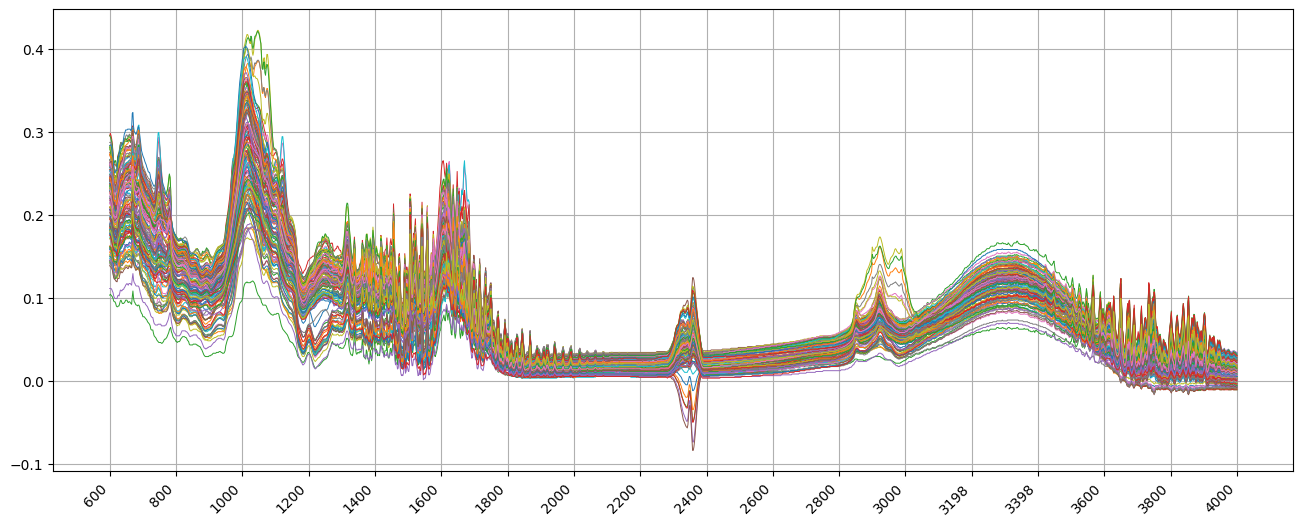

In [7]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.plot(X.T, linewidth = 0.7)
loc = plticker.MultipleLocator(base=100.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
# ax.set_xticks(rotation = 90)
plt.grid()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
plt.show()

In [8]:
X = np.array(X)  # In case it's not already a NumPy array
y = np.array(y)

n_classes = len(np.unique(y))
# Define how many samples per class you want in the validation set
n_test_samples_per_class = int(len(X) * 0.25 / n_classes)  # Modify this based on your need

# Get unique class labels
classes = np.unique(y)
# Lists to hold train and test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# For each class, split data to have equal test size
for cls in classes:
    # Get indices for this class
    class_indices = np.where(y == cls)[0]
    
    # Split the data for this class
    X_class, X_class_test, y_class, y_class_test = train_test_split(
        X[class_indices], y[class_indices], test_size=n_test_samples_per_class, random_state=42
    )
    
    # Append the splits to the train/test lists
    X_train_list.append(X_class)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class)
    y_test_list.append(y_class_test)

# Combine back into arrays
X_train = np.vstack(X_train_list)  # Combine all classes' training data
X_test = np.vstack(X_test_list)      # Combine all classes' test data
y_train = np.hstack(y_train_list)  # Combine all classes' training labels
y_test = np.hstack(y_test_list)      # Combine all classes' test labels

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_test.shape, y_test.shape)

Training set shape: (107, 1701) (107,)
Validation set shape: (32, 1701) (32,)


In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [10]:
onehot = OneHotEncoder(sparse_output=False)
y_train = onehot.fit_transform(y_train.reshape(-1,1))
y_test = onehot.transform(y_test.reshape(-1,1))

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
import tensorflow as tf
import random

tf.random.set_seed(1)
random.seed(1)
np.random.seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1], 1)))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3))
# model.add(tf.keras.layers.Conv1D(filters=24, kernel_size=3))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer="Adam", loss = 'CategoricalCrossentropy', metrics = ['accuracy'])
history=model.fit(X_train, y_train, batch_size=12, epochs=24, validation_data=(X_test, y_test))

Epoch 1/24


I0000 00:00:1740554378.595677   30252 service.cc:148] XLA service 0x702b4002c4b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740554378.595695   30252 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-26 14:19:38.615380: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740554378.842581   30252 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.3901 - loss: 1.3471 - val_accuracy: 0.3125 - val_loss: 1.2829
Epoch 2/24
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.4222 - loss: 1.2151 - val_accuracy: 0.3125 - val_loss: 1.3186
Epoch 3/24
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.4487 - loss: 1.1370 - val_accuracy: 0.5625 - val_loss: 1.1138
Epoch 4/24
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.5407 - loss: 1.0063 - val_accuracy: 0.7188 - val_loss: 0.8316
Epoch 5/24
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.6269 - loss: 0.8748 - val_accuracy: 0.7188 - val_loss: 0.7430
Epoch 6/24
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6648 - loss: 0.7563 - val_accuracy: 0.7188 - val_loss: 0.6514
Epoch 7/24
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.7555 - loss: 0.6712 - val_accuracy: 0.8438 - val_loss: 0.5065
Epoch 8/24
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.7828 - loss: 0.5815 - val_accuracy: 0.8438 - val_loss: 0.4401
Epo

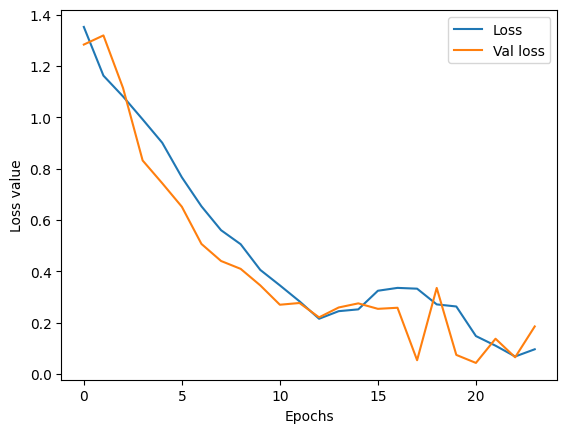

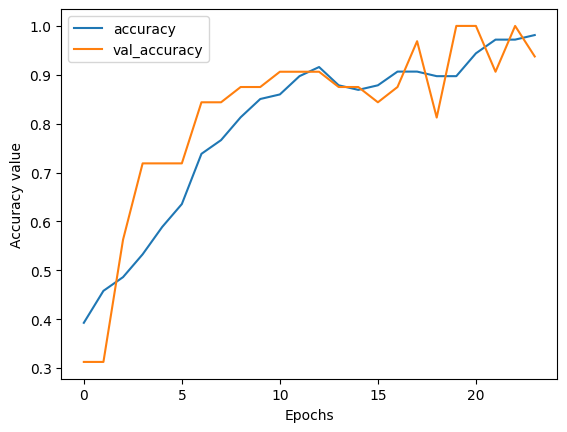

In [13]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
0.9375


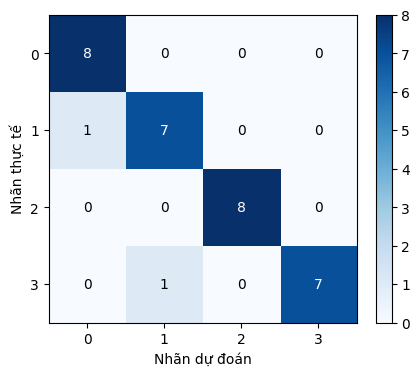

In [14]:
from mlxtend.plotting import plot_confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
print(accuracy_score(y_test_m, y_pred))
# print(precision_score(y_test_m, y_pred))
# print(recall_score(y_test_m, y_pred))
# print(f1_score(y_test_m, y_pred))
cm = confusion_matrix(y_test_m, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, figsize=(5,4))
plt.rcParams.update({'font.size': 11})
plt.xlabel("Nhãn dự đoán")
plt.ylabel("Nhãn thực tế")
plt.show()

In [15]:
print(classification_report(y_test_m, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.88      0.88      0.88         8
           2       1.00      1.00      1.00         8
           3       1.00      0.88      0.93         8

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32

